In [5]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import swifter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
import string
from sklearn.model_selection import cross_val_score, GridSearchCV
import joblib

In [6]:
# Download NLTK resources
nltk.download('stopwords')
if not nltk.download('punkt'):
    print("NLTK resource 'punkt' downloaded.")
if not nltk.download('stopwords'):
    print("NLTK resource 'stopwords' downloaded.")
if not nltk.download('wordnet'):
    print("NLTK resource 'wordnet' downloaded.")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
# Load the dataset
df = pd.read_csv('/workspaces/imdb-sentiment-analysis/imdb_dataset.csv')
df.head()

# Make a copy of the dataset
df_copy = df.copy()

In [8]:
# Data Exploration
print(df_copy.shape)
print(df_copy.columns)
print(df_copy.info())
print(df_copy.describe())
print(df_copy.isnull().sum())
print(df_copy.duplicated().sum())
print(df_copy.nunique())
print(df_copy['sentiment'].value_counts())

(50000, 2)
Index(['review', 'sentiment'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None
                                                   review sentiment
count                                               50000     50000
unique                                              49582         2
top     Loved today's show!!! It was a variety and not...  positive
freq                                                    5     25000
review       0
sentiment    0
dtype: int64
418
review       49582
sentiment        2
dtype: int64
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


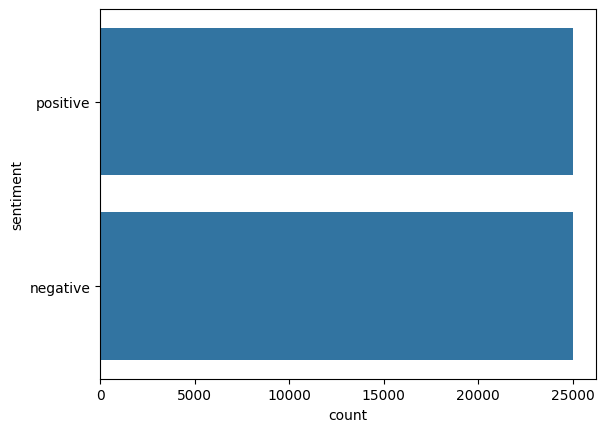

In [9]:
# Data Visualization
sns.countplot(df_copy['sentiment'])
plt.show()

In [10]:
# Word Cloud Function
def generate_word_cloud(sentiment_text, title):
    plt.figure(figsize=(20, 20))
    wordcloud = WordCloud(width=1000, height=500, stopwords=STOPWORDS, background_color='white').generate(str(sentiment_text))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()

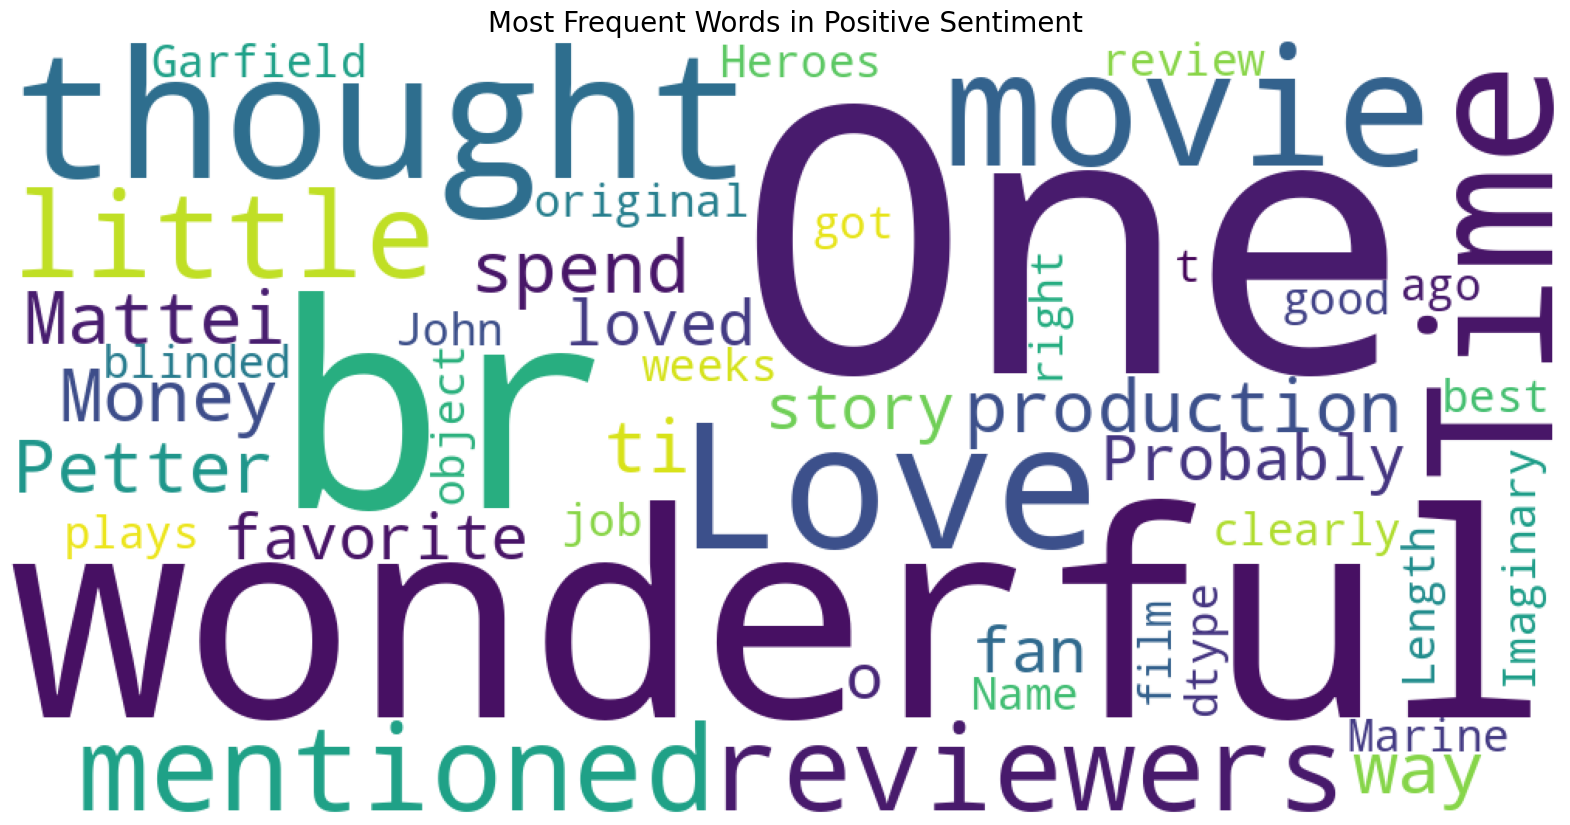

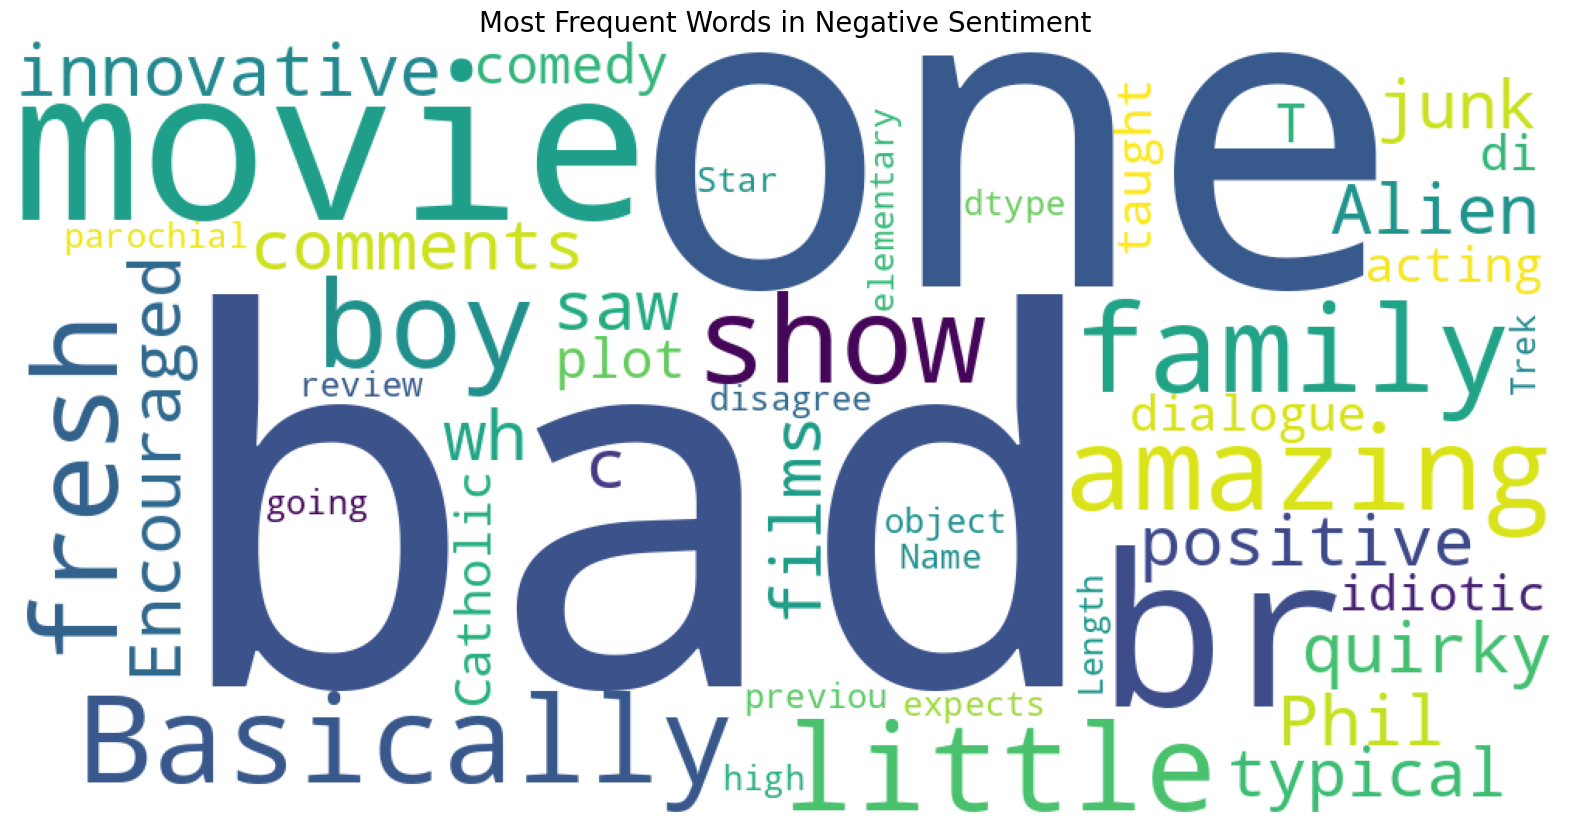

In [11]:
# Word Clouds for Positive and Negative Sentiment
positive_text = df_copy[df_copy['sentiment'] == 'positive']['review']
generate_word_cloud(positive_text, 'Most Frequent Words in Positive Sentiment')

negative_text = df_copy[df_copy['sentiment'] == 'negative']['review']
generate_word_cloud(negative_text, 'Most Frequent Words in Negative Sentiment')

In [12]:
# Load stopwords once
stop_words = set(stopwords.words('english'))

In [13]:
# Text Cleaning and Preprocessing
def clean_text(text):
    clean = re.compile('<.*?>')
    text = re.sub(clean, '', text)
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern, '', text)
    text = text.lower()
    text = text.strip()
    return " ".join(text.split())

def lemmatize_text(text, stop_words):
    words = nltk.word_tokenize(text)
    words = [w for w in words if w not in stop_words]
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmas)

In [14]:
# Apply the functions to the 'review' column
df_copy['cleaned_review'] = df_copy['review'].swifter.apply(lambda x: lemmatize_text(clean_text(x), stop_words))

Pandas Apply:   0%|          | 0/50000 [00:00<?, ?it/s]

In [15]:
# Display the cleaned text
print(df_copy[['review', 'cleaned_review']].head())

                                              review  \
0  One of the other reviewers has mentioned that ...   
1  A wonderful little production. <br /><br />The...   
2  I thought this was a wonderful way to spend ti...   
3  Basically there's a family where a little boy ...   
4  Petter Mattei's "Love in the Time of Money" is...   

                                      cleaned_review  
0  one reviewer mentioned watching 1 oz episode y...  
1  wonderful little production filming technique ...  
2  thought wonderful way spend time hot summer we...  
3  basically there family little boy jake think t...  
4  petter matteis love time money visually stunni...  


In [16]:
# Additional Data Exploration
df_copy.head()
df_copy.tail()
df_copy['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [17]:
# Add a column for text lengths
df_copy['text_length'] = df_copy['review'].apply(len)

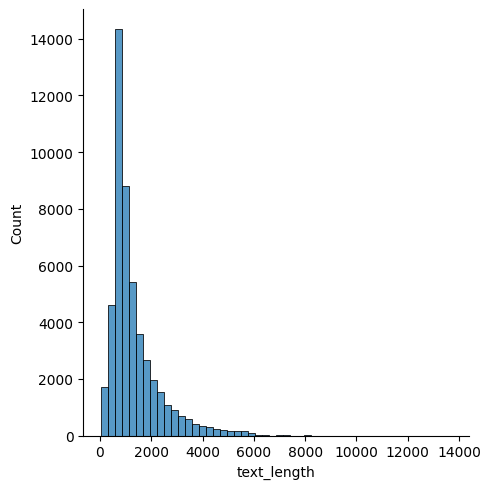

In [18]:
# Create a figure-level function with displot
sns.displot(df_copy['text_length'], bins=50, kde=False)

# Customize the plot
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths')

# Show the plot
plt.show()

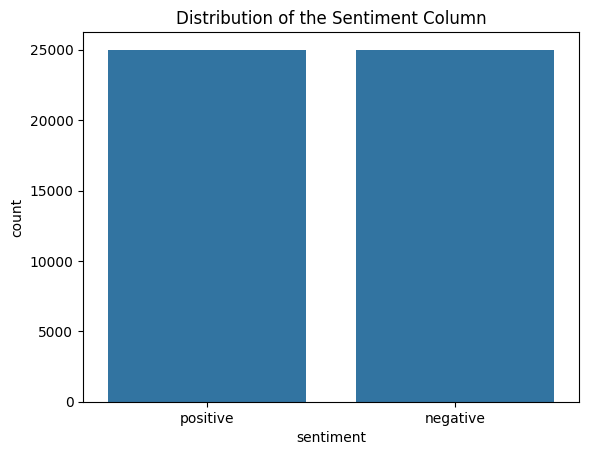

In [21]:
# Visualize the distribution of the sentiment column
sns.countplot(x='sentiment', data=df_copy)
plt.title('Distribution of the Sentiment Column')
plt.show()

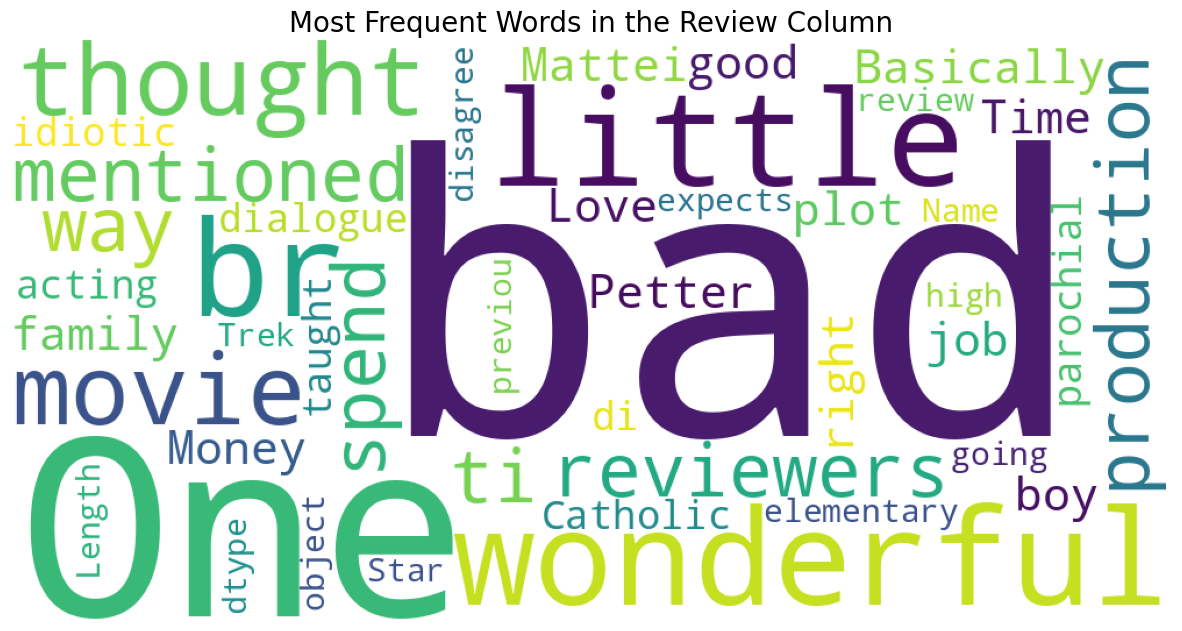

In [22]:
# Explore word frequencies in the review column
wordcloud = WordCloud(width=1000, height=500, stopwords=STOPWORDS, background_color='white').generate(str(df_copy['review']))
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Most Frequent Words in the Review Column', fontsize=20)
plt.show()

In [23]:
# Map sentiment labels to numerical values
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

In [24]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_copy['cleaned_review'], df_copy['sentiment'], test_size=0.2, random_state=42)

In [25]:
# Vectorize the cleaned text data using CountVectorizer
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

In [26]:
# Train a Naive Bayes classifier
classifier = MultinomialNB()
classifier.fit(X_train_vectorized, y_train)

MultinomialNB()

In [27]:
# Make predictions on the test set
predictions = classifier.predict(X_test_vectorized)

In [28]:
# Evaluate the classifier
accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

Accuracy: 0.8609
Classification Report:
              precision    recall  f1-score   support

    negative       0.85      0.87      0.86      4961
    positive       0.87      0.85      0.86      5039

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [29]:
# Define the model (e.g., MultinomialNB)
classifier = MultinomialNB()

In [30]:
# Define hyperparameters to tune
param_grid = {'alpha': [0.1, 0.5, 1.0]}

In [31]:
# Perform grid search with cross-validation
grid_search = GridSearchCV(classifier, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_vectorized, y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.1, 0.5, 1.0]}, scoring='accuracy')

In [32]:
# Get the best hyperparameters
best_alpha = grid_search.best_params_['alpha']

In [33]:
# Train the model with the best hyperparameters
best_classifier = MultinomialNB(alpha=best_alpha)
best_classifier.fit(X_train_vectorized, y_train)

MultinomialNB()

In [34]:
# Make predictions on the test set
predictions = best_classifier.predict(X_test_vectorized)

In [35]:
# Evaluate the classifier
accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)

print(f'Best Alpha: {best_alpha}')
print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

Best Alpha: 1.0
Accuracy: 0.8609
Classification Report:
              precision    recall  f1-score   support

    negative       0.85      0.87      0.86      4961
    positive       0.87      0.85      0.86      5039

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [36]:
# Identify indices of misclassified examples by comparing predicted and true labels
misclassified_indices = [i for i in range(len(predictions)) if predictions[i] != y_test.iloc[i]]

In [37]:
# Extract misclassified examples from the test set
misclassified_examples = X_test.iloc[misclassified_indices]

In [38]:
# Extract true labels of misclassified examples
true_labels = y_test.iloc[misclassified_indices]

In [39]:
# Extract predicted labels of misclassified examples
predicted_labels = predictions[misclassified_indices]

In [40]:
# Loop through a maximum of 5 misclassified examples
for i in range(min(5, len(misclassified_indices))):
    print(f"Example {i + 1}:")
    print(f"True Label: {true_labels.iloc[i]}")
    print(f"Predicted Label: {predicted_labels[i]}")
    print(f"Review: {misclassified_examples.iloc[i]}\n")

Example 1:
True Label: positive
Predicted Label: negative
Review: okay didnt get purgatory thing first time watched episode seemed like something significant going couldnt put finger time costa mesa fire tv really caught attention helped writing essay inferno let see hasnt discussed yeta twop review mentioned tony 7 flight stair go broken elevator yeah 7 significant number lot reason especially religious here one ya hunch consulted wikipedia guess dante divided 7 level purgatorio excluding antepurgatory paradise stuff bottom stair tony cant get allegedly random monkslap scene soon monk appeared fit perfectly place tony trying get purgatory tell got worried christian commercial death disease sin came he getting desperate christian heaven looking kinda iffy time meet monk he thinking hey maybe guy help sound like contemplating religion eg buddhism wondering path could take salvation tony necessarily literally thinking becoming buddhist appears finnerty tried messed slap face basically te

In [41]:
# Calculate the total number of misclassified examples
total_misclassified = len(misclassified_indices)

In [42]:
# Calculate the percentage of misclassified positive reviews
misclassified_positive_percentage = (sum(true_labels == 1) / total_misclassified) * 100

In [43]:
# Calculate the percentage of misclassified negative reviews
misclassified_negative_percentage = (sum(true_labels == 0) / total_misclassified) * 100

In [44]:
# Print the percentages
print(f"Percentage of Misclassified Positive Reviews: {misclassified_positive_percentage:.2f}%")
print(f"Percentage of Misclassified Negative Reviews: {misclassified_negative_percentage:.2f}%")

Percentage of Misclassified Positive Reviews: 0.00%
Percentage of Misclassified Negative Reviews: 0.00%


In [45]:
# Save the best classifier and vectorizer to files
joblib.dump(best_classifier, 'sentiment_model.joblib')
joblib.dump(vectorizer, 'sentiment_vectorizer.joblib')

['sentiment_vectorizer.joblib']

In [46]:
# Later, load the model and vectorizer for predictions
loaded_model = joblib.load('sentiment_model.joblib')
loaded_vectorizer = joblib.load('sentiment_vectorizer.joblib')

In [47]:
# Define a function for predicting sentiment on new reviews
def predict_sentiment(model, vectorizer, reviews):
    reviews_vectorized = vectorizer.transform(reviews)
    predictions = model.predict(reviews_vectorized)
    return predictions

In [48]:
# Example usage
new_reviews = ["This movie is great!", "I didn't like the acting."]
predictions_new = predict_sentiment(loaded_model, loaded_vectorizer, new_reviews)
print("Predictions on new reviews:")
print(predictions_new)

Predictions on new reviews:
['positive' 'negative']
